In [1]:
import rosbag
import numpy as np
import sys
import csi_utils.constants as constants
import csi_utils.transform_utils as transform_utils
import csi_utils.pipeline_utils as pipeline_utils
import csi_utils.comp_utils as comp_utils
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.cm import ScalarMappable
import mne

In [2]:
# Define variables to store your data
comp = np.load("192.168.43.1-157.npy")
apply_nts = True
idx = 0
valid_tx_ant = [0,1,2,3]
# mne.beamformer.rap_music()

In [3]:
def draw_channel_image_4x4(channel_1, channel_2):
    print("afad")
    num_tx_slots = channel_1.shape[2]
    num_rx_slots = channel_1.shape[1]
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    fig, axs = plt.subplots(num_tx_slots*2, num_rx_slots, figsize=(24, 24),
                            gridspec_kw={'height_ratios': [1, 0.7] * num_tx_slots})
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    amplitude_1 = (np.abs(channel_1))
    amplitude_2 = (np.abs(channel_2))
    min_amp = min(np.min(amplitude_1), np.min(amplitude_2))
    max_amp = max(np.max(amplitude_1), np.max(amplitude_2))
    phase_1 = np.unwrap(np.angle(channel_1))
    phase_2 = np.unwrap(np.angle(channel_2))
    min_phase = min(np.min(phase_1), np.min(phase_2))
    max_phase = max(np.max(phase_1), np.max(phase_2))
    print(min_phase, max_phase)
    for i in range(0, num_tx_slots*2, 2):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0, f"Tx Ant {i//2}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude (dB)")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            # axs[i, j].plot(20*np.log10(np.abs(channel_1[:, j, i//2])),
            #                label="LOS")
            axs[i, j].plot((np.abs(channel_1[:, j, i//2])),
                           label="LOS")
            # axs[i, j].plot(20*np.log10(np.abs(channel_2[:, j, i//2])),
                        #    label="NLOS")
            axs[i, j].legend()
            # plot phase
            axs[i+1, j].set_xlabel("Subcarrier indices")
            axs[i+1, j].set_ylabel("Phase (deg)")
            axs[i+1, j].set_ylim(min_phase, max_phase)
            axs[i+1, j].set_yticks(y_tick_positions)
            axs[i+1, j].set_yticklabels(y_tick_labels)
            # don't wrap 
            # axs[i+1, j].plot(np.angle(channel_1[:, j, i//2]),
            #                  label="LOS")
            # axs[i+1, j].plot(np.angle(channel_2[:, j, i//2]),
            #                  label="NLOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_1[:, j, i//2])),
                             label="LOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_2[:, j, i//2])),
                             label="NLOS2")
            axs[i+1, j].legend() 
    fig.set_tight_layout(True)   
    plt.savefig('40 157 los vs nlos.png')
    plt.show()
   

def draw_amplitude_4x4(channel, figure_title=""):
    print("afad")
    num_tx_slots = channel.shape[2]
    num_rx_slots = channel.shape[1]
    fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    amplitude = (np.abs(channel))
    min_amp = np.min(amplitude)
    max_amp = np.max(amplitude)
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            axs[i, j].plot((np.abs(channel[:, j, i])),
                           label="LOS")
            axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    plt.show()

In [4]:
def draw_amplitudes_4x4(bag, figure_title="", average=False, fig=None, axs=None, show=True, min_a=None, max_a=None):
    print("afad")
    num_tx_slots = 4
    num_rx_slots = 4
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    if (fig is None):
        fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
        fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    # amplitude = (np.abs(channel))
    min_amp = 1000
    max_amp = -1000
    # phase = np.unwrap(np.angle(channel))
    # min_phase = np.min(phase)
    # max_phase = np.max(phase)
    
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
                if i == 0:
                    # Place Rx antenna labels at the top
                    axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
                if j == 0:
                # Place Tx antenna labels on the left 
                    axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                k = 20
                if not average:
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        amplitude = (np.abs(channel))
                        min_amp = min(np.min(amplitude), min_amp)
                        max_amp = max(np.max(amplitude), max_amp)
                        # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                        axs[i, j].plot((amplitude[:, j, i]), label="l")
                        k += 1
                        if k == 30:
                            break
                else:
                    totalValues = None
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        if totalValues is None:
                            totalValues = channel
                        else:
                            totalValues += channel
                        k += 1
                        if k == 30:
                            break
                    amplitude = (np.abs(totalValues))
                    min_amp = min(np.min(amplitude), min_amp)
                    max_amp = max(np.max(amplitude), max_amp)
                    # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                    axs[i, j].plot((amplitude[:, j, i]), label="l")
                     

                    
                # plot magnitude
                axs[i, j].set_xlabel("Subcarrier indices")
                axs[i, j].set_ylabel("Magnitude")
                if (min_a != None):
                     min_amp = min_a
                if (max_a != None):
                     max_amp = max_a
                mi, ma = axs[i, j].get_ylim()
                axs[i, j].set_ylim(min(mi,min_amp-10), max(ma, max_amp+10))

                # axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    if show:
        plt.show()

In [5]:
def compare_amplitudes_4x4(bags, figure_title=""):
    fig, axs = plt.subplots(4, 4, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    for bag in bags:
        print("drawing bag")
        draw_amplitudes_4x4(bag, "", True, fig, axs, False)
    for i in range(4):
        for j in range(4):
            axs[i, j].legend([f"Location {k}" for k in range(1, 6)])
    plt.show()

In [6]:
# headon = rosbag.Bag("../HeadOn.bag")
# ninetydeg = rosbag.Bag("../90deg2.bag")
# fortyfive = rosbag.Bag("../45deg.bag")
# nfortyfive = rosbag.Bag("../n45deg.bag")
import tqdm
#smooth over last n packets according to algo
smoothing_window = 1
#aoa search space
theta_space = np.linspace(-np.pi/2,np.pi/2,360)
#tof search space
tof_space = np.linspace(-40,40,240)

#antenna position (interleaved x-y), see antennas.md
rx_pos = np.asarray([0,  0,
    0,  -0.06,
    0,  -0.03,
    0,  -0.09]).reshape((-1,2))
channels = {}
times = {}
aoas = {}
rssis = {}
profs = {}
aoa_sensors = {}


In [31]:
def get_angle_profiles(bag, algorithm, subcarriers = range(0, 50)):
  """Returns a list of [(time, [angles], [profile])] for each packet

  Arguments:
  - bag: The bag with csi data to get the angle profiles from
  - algorithm: The algorithm to use to get the angle likelihood ("music", "aoa", "fft")
  - subcarriers: The subcarriers to use for the algorithm. Should be a subset of the integers from 0 to 49
  """
  print("ALGORITHM:", algorithm)
  num = 0
  data = []
  aoa_sensor = None
  if algorithm == "music":
    aoa_sensor = transform_utils.music_aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
    aoa_sensor.prof_dim = 4
  elif algorithm == "aoa":
    aoa_sensor = transform_utils.aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
  elif algorithm == "fft":
    aoa_sensor = transform_utils.fft_aoa_sensor(rx_pos, theta_space, smoothing_window)
  elif algorithm == "othermusic":
    tofs = np.linspace(-40, 40, 180)
    aoa_sensor = transform_utils.full_music_aoa_sensor(rx_pos, theta_space, tofs, smoothing_window)
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      #assuming this does not change
      if algorithm == "othermusic":
        res = aoa_sensor(csi, (msg.chan, msg.bw*1e6))
        print("Channel:", msg.chan, " BW:", msg.bw*1e6)
      else:
        res = aoa_sensor.run(csi,(msg.chan,msg.bw*1e6), subcarriers=subcarriers)
      num += 1
      data.append((t.to_sec(), theta_space * 180 / np.pi, res[1]))
  print("Packets:", num)
  return data

def plot_angle_profiles(data, title, tof_indices = None, savename=None):
  """Plots a list of [(time, [angles], [profile])]"""
  fig, ax = plt.subplots()
  plt.title(title)
  plt.ylabel("Angle (degrees)")
  plt.xlabel("Time")
  for time, angles, profile in data:
    if tof_indices is not None:
      start_i = tof_indices[0]
      end_i = tof_indices[1]
      ax.scatter([time] * len(angles), angles, c=np.max(profile[:, start_i:end_i], axis=1), s=10)
    else:
      ax.scatter([time] * len(angles), angles, c=profile, s=10)
  if savename is not None:
    plt.savefig(savename)
  plt.show()

ALGORITHM: music


311it [00:00, 2922.76it/s]


(50, 4, 4)
Packets: 311
ALGORITHM: music


0it [00:00, ?it/s]

(50, 4, 4)


311it [00:00, 2907.36it/s]


Packets: 311
ALGORITHM: music


231it [00:00, 2902.89it/s]


(50, 4, 4)
Packets: 231
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


231it [00:00, 2905.48it/s]


Packets: 231
ALGORITHM: music


0it [00:00, ?it/s]

(50, 4, 4)


408it [00:00, 2992.43it/s]


Packets: 408
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


408it [00:00, 2921.28it/s]


Packets: 408
ALGORITHM: othermusic


2it [00:00, 12.28it/s]

Channel: 157  BW: 20000000.0
(50, 4, 4)
Channel: 157  BW: 20000000.0


4it [00:00, 13.98it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


8it [00:00, 14.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


10it [00:00, 13.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


12it [00:00, 13.36it/s]

Channel: 157  BW: 20000000.0


14it [00:01, 13.18it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


16it [00:01, 13.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


18it [00:01, 13.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


20it [00:01, 13.99it/s]

Channel: 157  BW: 20000000.0


22it [00:01, 13.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


24it [00:01, 12.49it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


26it [00:01, 12.75it/s]

Channel: 157  BW: 20000000.0


28it [00:02, 13.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


30it [00:02, 13.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


34it [00:02, 12.10it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


36it [00:02, 12.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


40it [00:03, 13.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


44it [00:03, 13.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


46it [00:03, 13.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


50it [00:03, 14.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


54it [00:04, 14.54it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


56it [00:04, 14.36it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


60it [00:04, 13.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


62it [00:04, 13.12it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


64it [00:04, 12.25it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


66it [00:05, 11.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


70it [00:05, 10.74it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


72it [00:05, 11.35it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


76it [00:05, 12.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


78it [00:06, 12.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


82it [00:06, 12.34it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


84it [00:06, 11.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


88it [00:06, 12.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


90it [00:07, 12.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


94it [00:07, 12.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


96it [00:07, 12.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


100it [00:07, 12.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


102it [00:07, 12.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


106it [00:08, 13.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


108it [00:08, 13.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


112it [00:08, 14.27it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


116it [00:08, 13.60it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


118it [00:09, 12.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


120it [00:09, 10.86it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


122it [00:09, 11.26it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


126it [00:09, 11.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


128it [00:10, 12.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


132it [00:10, 12.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


136it [00:10, 13.62it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


138it [00:10, 13.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


142it [00:11, 14.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


146it [00:11, 14.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


148it [00:11, 13.53it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


152it [00:11, 13.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


156it [00:12, 14.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


158it [00:12, 14.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


162it [00:12, 13.55it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


166it [00:12, 14.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


170it [00:13, 15.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


172it [00:13, 15.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


176it [00:13, 14.88it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


178it [00:13, 14.60it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


182it [00:13, 14.77it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


186it [00:14, 13.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


188it [00:14, 14.10it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


192it [00:14, 12.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


194it [00:14, 13.27it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


198it [00:15, 13.04it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


200it [00:15, 13.73it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


204it [00:15, 14.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


208it [00:15, 14.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


210it [00:15, 15.04it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


214it [00:16, 12.95it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


218it [00:16, 14.28it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


220it [00:16, 14.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


224it [00:16, 13.79it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


226it [00:17, 13.68it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


230it [00:17, 12.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


232it [00:17, 12.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


234it [00:17, 11.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


238it [00:18, 13.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


240it [00:18, 13.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


244it [00:18, 13.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


246it [00:18, 13.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


250it [00:18, 12.44it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


252it [00:19, 13.00it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


256it [00:19, 13.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


258it [00:19, 13.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


262it [00:19, 13.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


264it [00:20, 13.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


268it [00:20, 12.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


270it [00:20, 12.34it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


274it [00:20, 13.39it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


278it [00:21, 14.85it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


282it [00:21, 15.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


286it [00:21, 14.97it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


290it [00:21, 14.60it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


294it [00:22, 14.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


296it [00:22, 14.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


300it [00:22, 14.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


304it [00:22, 15.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


308it [00:23, 15.75it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


310it [00:23, 14.85it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


314it [00:23, 14.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


318it [00:23, 14.54it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


322it [00:23, 15.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


324it [00:24, 14.98it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


328it [00:24, 14.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


332it [00:24, 14.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


336it [00:24, 15.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


340it [00:25, 15.44it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


342it [00:25, 15.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


346it [00:25, 14.97it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


350it [00:25, 15.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


354it [00:26, 14.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


358it [00:26, 13.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


360it [00:26, 13.79it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


364it [00:26, 13.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


366it [00:27, 12.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


370it [00:27, 12.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


372it [00:27, 12.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


376it [00:27, 13.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


378it [00:27, 13.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


382it [00:28, 14.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


384it [00:28, 13.28it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


386it [00:28, 13.66it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


390it [00:28, 13.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


394it [00:29, 12.14it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


396it [00:29, 12.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


400it [00:29, 13.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


404it [00:29, 14.82it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


406it [00:30, 12.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


408it [00:30, 13.49it/s]


Channel: 157  BW: 20000000.0
Packets: 408
ALGORITHM: music


416it [00:00, 3035.74it/s]


(50, 4, 4)
Packets: 416
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


416it [00:00, 2984.79it/s]


Packets: 416
ALGORITHM: othermusic


2it [00:00, 15.73it/s]

Channel: 157  BW: 20000000.0
(50, 4, 4)
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


4it [00:00, 15.05it/s]

Channel: 157  BW: 20000000.0


6it [00:00, 15.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


8it [00:00, 15.00it/s]

Channel: 157  BW: 20000000.0


10it [00:00, 15.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


12it [00:00, 15.31it/s]

Channel: 157  BW: 20000000.0


14it [00:00, 15.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


16it [00:01, 15.61it/s]

Channel: 157  BW: 20000000.0


18it [00:01, 15.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


20it [00:01, 15.57it/s]

Channel: 157  BW: 20000000.0


22it [00:01, 15.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


24it [00:01, 14.49it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


26it [00:01, 14.16it/s]

Channel: 157  BW: 20000000.0


28it [00:01, 14.68it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


30it [00:01, 14.89it/s]

Channel: 157  BW: 20000000.0


32it [00:02, 13.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


34it [00:02, 14.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


36it [00:02, 14.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


38it [00:02, 14.18it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


40it [00:02, 14.57it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


42it [00:02, 14.65it/s]

Channel: 157  BW: 20000000.0


44it [00:02, 14.97it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


46it [00:03, 15.48it/s]

Channel: 157  BW: 20000000.0


48it [00:03, 14.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


50it [00:03, 15.36it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


52it [00:03, 14.53it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


54it [00:03, 13.38it/s]

Channel: 157  BW: 20000000.0


56it [00:03, 13.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


58it [00:03, 13.57it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


60it [00:04, 13.68it/s]

Channel: 157  BW: 20000000.0


62it [00:04, 14.12it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


64it [00:04, 13.41it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


66it [00:04, 12.83it/s]

Channel: 157  BW: 20000000.0


68it [00:04, 13.27it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


72it [00:04, 14.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


76it [00:05, 14.86it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


80it [00:05, 13.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


82it [00:05, 13.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


84it [00:05, 12.30it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


88it [00:06, 13.25it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


92it [00:06, 14.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


96it [00:06, 14.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


98it [00:06, 14.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


102it [00:07, 14.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


106it [00:07, 15.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


110it [00:07, 15.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


114it [00:07, 15.30it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


118it [00:08, 15.10it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


122it [00:08, 14.64it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


124it [00:08, 14.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


128it [00:08, 14.04it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


132it [00:09, 15.00it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


134it [00:09, 14.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


138it [00:09, 14.07it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


140it [00:09, 14.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


144it [00:10, 12.92it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


146it [00:10, 12.28it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


150it [00:10, 11.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


152it [00:10, 11.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


156it [00:11, 11.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


158it [00:11, 12.44it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


162it [00:11, 13.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


166it [00:11, 13.09it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


168it [00:12, 13.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


172it [00:12, 12.34it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


174it [00:12, 12.88it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


178it [00:12, 12.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


180it [00:12, 13.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


184it [00:13, 12.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


188it [00:13, 13.75it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


190it [00:13, 13.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


194it [00:14, 12.36it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


196it [00:14, 12.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


200it [00:14, 13.35it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


202it [00:14, 13.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


206it [00:14, 12.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


208it [00:15, 12.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


212it [00:15, 13.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


214it [00:15, 13.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


218it [00:15, 13.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


220it [00:15, 13.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


224it [00:16, 12.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


226it [00:16, 12.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


230it [00:16, 12.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


232it [00:16, 13.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


236it [00:17, 12.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


238it [00:17, 11.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


240it [00:17, 12.39it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


242it [00:17, 12.81it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


246it [00:18, 12.02it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


248it [00:18, 12.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


250it [00:18, 12.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


254it [00:18, 11.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


256it [00:18, 11.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


260it [00:19, 12.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


262it [00:19, 12.65it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


266it [00:19, 12.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


268it [00:19, 12.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


272it [00:20, 11.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


274it [00:20, 11.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


278it [00:20, 11.18it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


280it [00:21, 10.85it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


284it [00:21, 11.60it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


286it [00:21, 11.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


290it [00:21, 11.49it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


292it [00:22, 11.64it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


296it [00:22, 12.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


298it [00:22, 12.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


302it [00:22, 13.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


306it [00:23, 14.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


308it [00:23, 14.28it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


312it [00:23, 13.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


314it [00:23, 13.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


318it [00:23, 13.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


322it [00:24, 14.09it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


326it [00:24, 13.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


328it [00:24, 13.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


332it [00:24, 12.69it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


334it [00:25, 12.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


338it [00:25, 14.09it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


342it [00:25, 14.10it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


344it [00:25, 13.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


348it [00:26, 12.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


350it [00:26, 13.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


354it [00:26, 13.14it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


356it [00:26, 13.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


360it [00:27, 13.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


362it [00:27, 12.54it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


366it [00:27, 12.00it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


370it [00:27, 13.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


374it [00:28, 14.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


378it [00:28, 15.26it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


380it [00:28, 14.82it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


384it [00:28, 15.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


388it [00:29, 15.04it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


390it [00:29, 14.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


394it [00:29, 14.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


398it [00:29, 14.79it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


400it [00:29, 15.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


404it [00:30, 14.41it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


406it [00:30, 14.27it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


410it [00:30, 14.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


414it [00:30, 13.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


416it [00:31, 13.41it/s]


Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Packets: 416


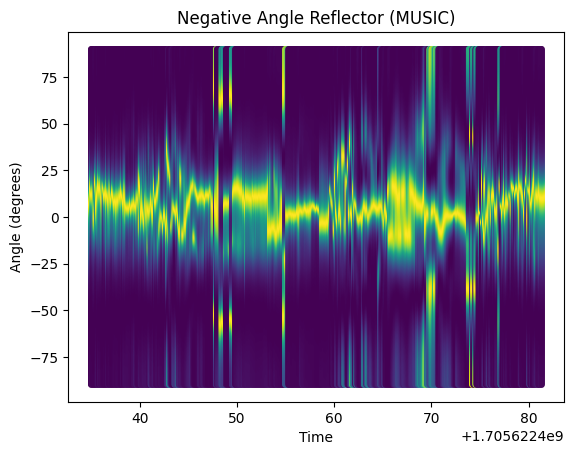

In [8]:
rotationData = rosbag.Bag("rotationData.bag")
controlData = rosbag.Bag("testingData/control.bag")
musicData1 = get_angle_profiles(rotationData, "music", [0, 10, 20, 30, 40, 49])
musicData2 = get_angle_profiles(rotationData, "music")

controlAnglesMusic = get_angle_profiles(controlData, "music")
controlAnglesAOA = get_angle_profiles(controlData, "aoa")

neg45Data = rosbag.Bag("testingData/reflector1.bag")
neg45AnglesMusic = get_angle_profiles(neg45Data, "music")
neg45AnglesAOA = get_angle_profiles(neg45Data, "aoa")
neg45AnglesOtherMusic = get_angle_profiles(neg45Data, "othermusic")


pos45Data = rosbag.Bag("testingData/reflector3.bag")
pos45AnglesMusic = get_angle_profiles(pos45Data, "music")
pos45AnglesAOA = get_angle_profiles(pos45Data, "aoa")
pos45AnglesOtherMusic = get_angle_profiles(pos45Data, "othermusic")
# aoaData = get_angle_profiles(rotationData, "aoa")
# clippedMusic = []
# for i in range(len(musicData)):
#   row = musicData[i][2].copy()
#   row[row < 1] = 0
#   clippedMusic.append((musicData[i][0], musicData[i][1], row))
# clippedAoa = []
# for i in range(len(aoaData)):
#   row = aoaData[i][2].copy()
#   row[row < 1] = 0
#   clippedAoa.append((aoaData[i][0], aoaData[i][1], row))
# clippedCombined = []
# for i in range(len(musicData)):
#   clippedCombined.append((musicData[i][0], musicData[i][1], clippedMusic[i][2] * clippedMusic[i][2]))

# differences = []
# for i in range(len(musicData)):
#   differences.append((musicData[i][0], musicData[i][1], np.isclose(musicData[i][2], aoaData[i][2], rtol=0.3)))

# print(neg45AnglesMusic)

# plot_angle_profiles(neg45AnglesAOA, "Negative Angle Reflector (AOA)")
plot_angle_profiles(neg45AnglesMusic, "Negative Angle Reflector (MUSIC)")
# plot_angle_profiles(neg45AnglesOtherMusic, "Negative Angle Reflector (Other MUSIC)")

In [24]:
controlAnglesOtherMusic = get_angle_profiles(controlData, "othermusic")

ALGORITHM: othermusic


2it [00:00, 14.87it/s]

Channel: 157  BW: 20000000.0
(50, 4, 4)
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


4it [00:00, 16.12it/s]

Channel: 157  BW: 20000000.0


6it [00:00, 14.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


10it [00:00, 14.85it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


12it [00:00, 15.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


14it [00:00, 14.07it/s]

Channel: 157  BW: 20000000.0


16it [00:01, 14.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


18it [00:01, 14.55it/s]

Channel: 157  BW: 20000000.0


20it [00:01, 13.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


22it [00:01, 13.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


24it [00:01, 13.10it/s]

Channel: 157  BW: 20000000.0


26it [00:01, 14.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


30it [00:02, 14.35it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


34it [00:02, 15.41it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


38it [00:02, 15.40it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


42it [00:02, 15.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


46it [00:03, 15.82it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


50it [00:03, 15.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


52it [00:03, 14.43it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


56it [00:03, 13.57it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


58it [00:03, 13.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


62it [00:04, 14.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


64it [00:04, 13.40it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


68it [00:04, 13.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


72it [00:04, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


74it [00:05, 15.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


78it [00:05, 13.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


82it [00:05, 13.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


86it [00:05, 14.65it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


88it [00:06, 14.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


92it [00:06, 14.39it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


96it [00:06, 12.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


100it [00:06, 13.92it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


104it [00:07, 14.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


108it [00:07, 15.43it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


112it [00:07, 15.28it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


116it [00:08, 15.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


120it [00:08, 14.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


124it [00:08, 15.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


128it [00:08, 14.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


130it [00:08, 14.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


134it [00:09, 14.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


138it [00:09, 14.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


142it [00:09, 14.75it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


146it [00:10, 15.02it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


148it [00:10, 15.04it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


152it [00:10, 14.51it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


156it [00:10, 15.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


160it [00:10, 15.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


164it [00:11, 15.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


168it [00:11, 14.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


170it [00:11, 14.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


174it [00:11, 15.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


178it [00:12, 14.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


182it [00:12, 15.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


186it [00:12, 15.68it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


190it [00:12, 15.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


194it [00:13, 15.26it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


196it [00:13, 15.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


200it [00:13, 15.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


204it [00:13, 13.14it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


208it [00:14, 14.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


212it [00:14, 14.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


216it [00:14, 15.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


220it [00:14, 15.97it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


224it [00:15, 16.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


226it [00:15, 15.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


230it [00:15, 14.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


231it [00:15, 14.67it/s]

Channel: 157  BW: 20000000.0
Packets: 231


In [187]:
def consolidateProfile(profile):
  return np.max(profile, axis=1)

snapshot = neg45AnglesOtherMusic[10]
profile = snapshot[2]
np.shape(profile[2][80])

# for i in range(0, 360) {
#   if (profile[2][i] )
# }
print(np.max(profile, axis=0))

len(profile[4])

[0.0707834  0.07077991 0.070776   0.07077202 0.07077128 0.07077947
 0.07079505 0.0708186  0.07084894 0.07088513 0.07092663 0.07097297
 0.07102354 0.07107775 0.07113473 0.07119362 0.07125354 0.07131332
 0.07137172 0.07142747 0.07147928 0.07152581 0.07156578 0.07159797
 0.07162124 0.07163462 0.07163742 0.07162906 0.07160916 0.07157768
 0.07153492 0.07148153 0.0714187  0.07134782 0.07127035 0.07118894
 0.07113813 0.07114827 0.07115461 0.07115687 0.07115481 0.07114828
 0.0711374  0.0711225  0.07110419 0.07108362 0.0710634  0.07105238
 0.07115045 0.07136337 0.0716292  0.07195252 0.07233766 0.0727894
 0.07331308 0.07391392 0.07459677 0.07536696 0.07622994 0.07719128
 0.07825666 0.07943177 0.08072279 0.08213723 0.08367876 0.08535223
 0.0871617  0.08911002 0.09119834 0.09342542 0.09578682 0.09827392
 0.10087278 0.10356282 0.10632152 0.10911396 0.11188694 0.11458244
 0.11713264 0.11946199 0.12149091 0.12314116 0.12434256 0.12504
 0.12519962 0.12481303 0.12390666 0.12253192 0.12073037 0.11857544

180

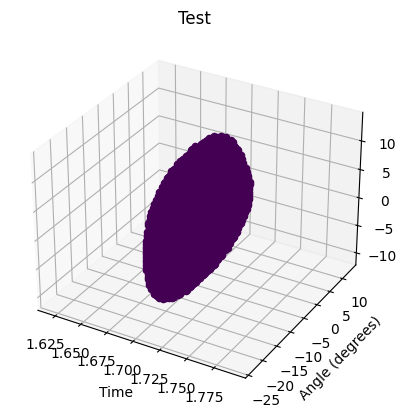

KeyboardInterrupt: 

In [9]:
# plot_angle_profiles(neg45AnglesMusic, "Positive Angle Reflector (MUSIC)")
# print("HEYYYY")
tofs = list(np.linspace(-40, 40, 180))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title("Test")
plt.ylabel("Angle (degrees)")
plt.xlabel("Time")
for time, angles, profile in pos45AnglesOtherMusic:
  newprofile = []
  for i in range(360):
    # print(profile[i])
    newprofile.append(profile[i][100])
    # newprofile.append(np.average(profile[i][0:8]))
  newprofile = np.array(newprofile)
  # print(np.shape(profile))
  # print(idx)
  # ax.scatter(time, angles[idx], s=10)
  for angleIdx in range(len(angles)):
    angle = angles[angleIdx]
    for tofIdx in range(len(tofs)):
      distance = tofs[tofIdx]
      intensity = profile[angleIdx][tofIdx]
      if (intensity > 0.077):
        ax.scatter(time, angle, distance, c=intensity)
  # ax.scatter([time] * len(angles), angles, c=newprofile, s=10)
  plt.show()

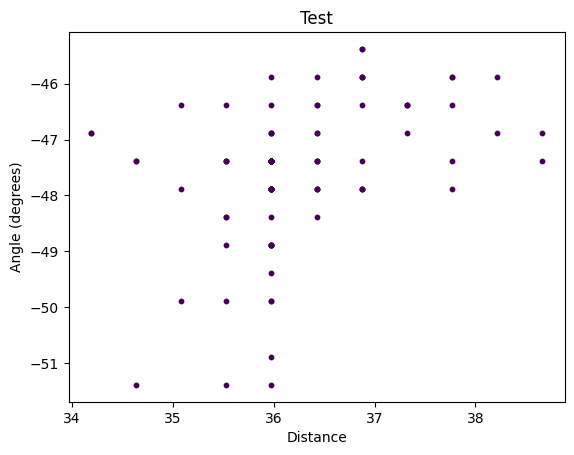

In [30]:
# plot_angle_profiles(neg45AnglesMusic, "Positive Angle Reflector (MUSIC)")
# print("HEYYYY")
tofs = list(np.linspace(-40, 40, 180))
fig, ax = plt.subplots()
plt.title("Test")
plt.ylabel("Angle (degrees)")
plt.xlabel("Distance")
for time, angles, profile in neg45AnglesOtherMusic[:100]:
  maxIdx = np.argmax(profile)
  maxAngleIdx = maxIdx % 180
  maxDistIdx = maxIdx // 180
  ax.scatter(tofs[maxDistIdx], angles[maxAngleIdx], c=profile[maxAngleIdx][maxDistIdx], s=10)
plt.show()

In [19]:
maxIdx = np.argmax(profile)
maxAngleIdx = maxIdx % 180
maxDistIdx = maxIdx // 180
print(maxAngleIdx, maxDistIdx, profile[maxDistIdx][maxAngleIdx])

93 171 0.12442321288927122


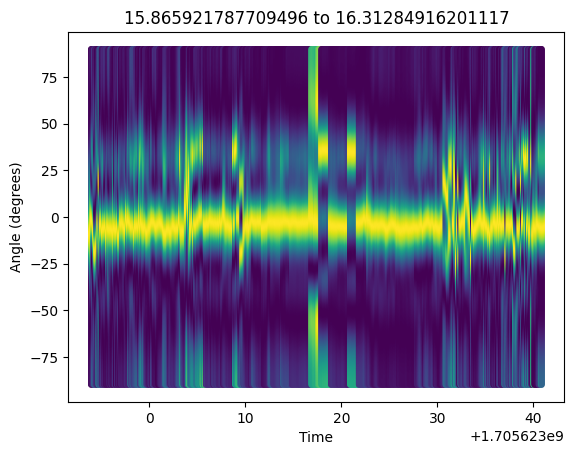

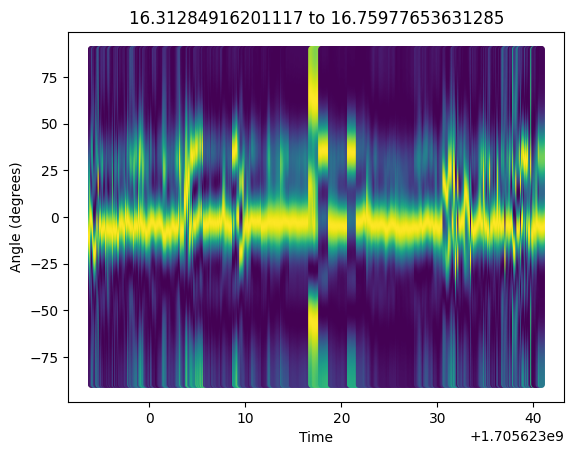

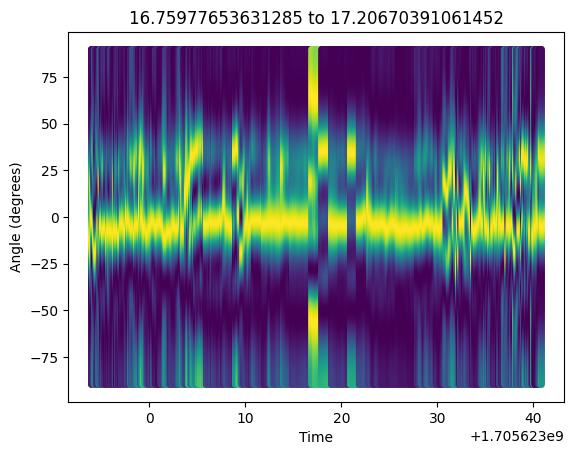

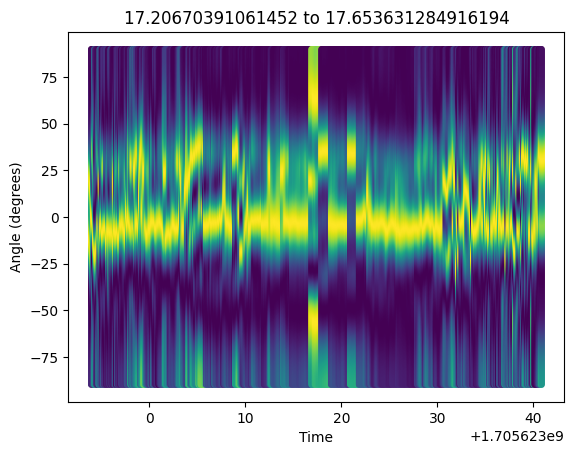

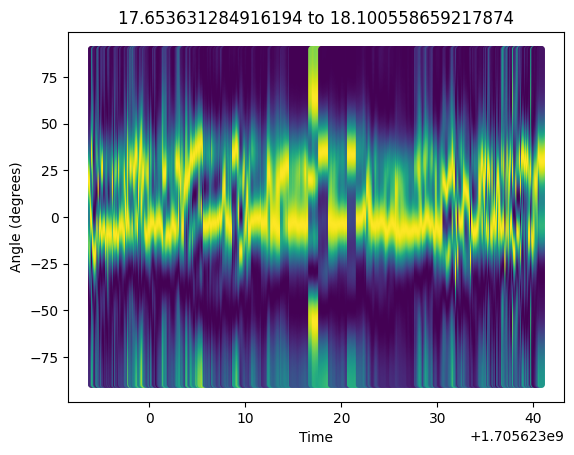

In [44]:
for i in range(5):
  minIndex = 125 + i
  maxIndex = 125 + i + 1
  title = f"{tofs[minIndex]} to {tofs[maxIndex]}"
  plot_angle_profiles(pos45AnglesOtherMusic, title, [minIndex, maxIndex])